In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("./dataset/INMET_GROUP_DATA.CSV", delimiter=";", decimal=",")
df

,Ano,Mês,Dia,Estacao,Precipitação total,Pressao media,Radiacao media,Temp bulbo seco media,Temp ponto orvalho media,Umidade media,Vento Rajada Media (m/s),Vento Velocidade Media (m/s),Rajada Vento escala Beaufort
0,2000,5,7,A001,0,886.091,-245.818,25.0000,12.81820,47.2727,3.81818,1.36364,3
1,2000,5,8,A001,0,887.667,-4107.580,21.7500,13.08330,60.5000,3.66667,1.58333,3
2,2000,5,9,A001,0,887.625,-4276.170,21.5833,12.66670,58.7917,2.45833,0.87500,2
3,2000,5,10,A001,0,888.458,-4180.290,21.9583,13.87500,61.7500,3.62500,1.45833,3
4,2000,5,11,A001,0,888.083,-4161.830,20.7917,13.04170,62.4167,5.04167,2.25000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2730936,2022,12,27,A898,0,904.208,841.083,20.7500,16.12500,77.1250,6.45833,3.12500,4
2730937,2022,12,28,A898,1,902.875,991.417,19.0417,15.00000,79.3333,8.45833,3.70833,4
2730938,2022,12,29,A898,0,905.958,1256.790,19.4167,8.91667,51.8750,4.70833,1.91667,3
2730939,2022,12,30,A898,0,907.208,1184.960,19.7500,11.45830,62.3750,6.16667,2.83333,4


In [3]:
# Append season to table
conditions = [
    (df['Mês'] == 12) & (df["Dia"] > 21),
    (df['Mês'] >= 1) & (df["Mês"] < 3),
    (df['Mês'] == 3) & (df["Dia"] <= 21),
    (df['Mês'] == 3) & (df["Dia"] > 21),
    (df['Mês'] >= 3) & (df["Mês"] < 6),
    (df['Mês'] == 6) & (df["Dia"] <= 21),
    (df['Mês'] == 6) & (df["Dia"] > 21),
    (df['Mês'] >= 7) & (df["Mês"] < 9),
    (df['Mês'] == 9) & (df["Dia"] <= 23),
    (df['Mês'] == 9) & (df["Dia"] > 23),
    (df['Mês'] >= 10) & (df["Mês"] < 12),
    (df['Mês'] == 12) & (df["Dia"] <= 21),
]

values = [
    "verao",
    "verao",
    "verao",
    "outono",
    "outono",
    "outono",
    "inverno",
    "inverno",
    "inverno",
    "primavera",
    "primavera",
    "primavera",
]

df["season"] = np.select(conditions, values)

# Vetor de estacoes e medidores com dados (>5 anos de coleta)
seasons = ["inverno", "outono", "primavera", "verao"]
regioes = {"N": "Norte", "SE": "Sudeste", "CO": "Centro Oeste", "NE": "Nordeste", "S": "Sul"}
medidores_inicial = df["Estacao"].unique()
medidores = []
i = 1
for medidor in medidores_inicial:
    print(f"{medidor} - {i}/{len(medidores_inicial)}", end="\r")
    i += 1
    ult_ano = df[df["Estacao"] == medidor]["Ano"].max()
    pri_ano = df[df["Estacao"] == medidor]["Ano"].min()
    if (ult_ano - pri_ano) > 5:
        medidores.append(medidor)    

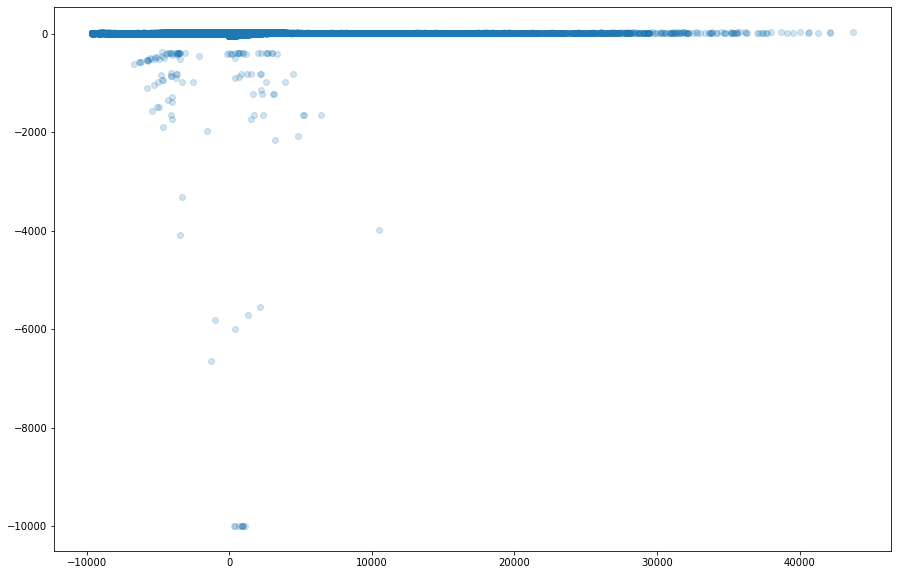

In [4]:
# Correlacionar radiacao com temperatura
df_rad = df[df["Radiacao media"] != -9999]
X = df_rad[["Radiacao media"]]
y = df_rad[["Temp bulbo seco media"]]

fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X, y, alpha=0.20)

In [5]:
def remove_outliers(data):
    Q1 = data["Temp bulbo seco media"].quantile(0.25)
    Q3 = data["Temp bulbo seco media"].quantile(0.75)
    data = data[(data["Temp bulbo seco media"] >= Q1) & (data["Temp bulbo seco media"] <= Q3)]
    return data

def get_monthly_mean(data, columns = "Temp bulbo seco media"):
    # Reduce number of elements by grouping in months
    return data.groupby(["Ano", "Mês"])[columns].mean().reset_index()

def regress(medidor, estacao, monthly = True):
    # Calculate coefficient and interception for regression line
    data = df[(df["Estacao"] == medidor) & (df["season"] == estacao)]
    data = remove_outliers(data)
    if monthly:
         data = get_monthly_mean(data)
    X = data[["Ano"]]
    y = data[["Temp bulbo seco media"]]
    if (len(X) == 0) or (len(y) == 0):
        return np.inf, np.inf
    reg = LinearRegression().fit(X, y)
    a = round(reg.coef_[0][0], 5)
    b = round(reg.intercept_[0], 5)
    return a, b

In [6]:
# Remove all values that are outstanding
df = df[df["Temp bulbo seco media"] != -9999]

In [7]:
# Runs for each station for each season finding the slope and intercept     
def run_all(monthly = False):
    coefs = {}
    ests = {}
    for season in seasons:
        ests[season] = []
    i = 1
    for medidor in medidores:
        print(f"{medidor} - {i}/{len(medidores)}", end="\r")
        values = []
        for season in seasons:
            coef, interc = regress(medidor, season, monthly)
            if coef == np.inf:
                values.append((np.inf, np.inf))
            values.append((coef, interc))
            ests[season].append(coef)
        coefs[medidor] = values
        i += 1

    return coefs, ests

In [8]:
coefs_monthly, ests_monthly = run_all()

In [9]:
def plot_reg_seasons(medidor, coefs):
    # Plots 4 graphs if possible one for each regression
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
    i, j = (0, 0)
    for estacao in seasons:
        data = df[(df["Estacao"] == medidor) & (df["season"] == estacao)]
        data = get_monthly_mean(data)
        years = data["Ano"].unique()
        
        data = remove_outliers(data)
        X = data[["Ano"]]
        y = data[["Temp bulbo seco media"]]
        axs[i][j].scatter(X, y)
        
        coef, interc = coefs[medidor][seasons.index(estacao)]
        y_p = (years * coef) + interc
        axs[i][j].plot(years, y_p, color="r")
        axs[i][j].set_title(f"{medidor} Temperatura media anual - {estacao}")
        axs[i][j].set_ylabel(f"Temperatura C°")
        axs[i][j].set_xlabel(f"Ano")
        min_temp = y["Temp bulbo seco media"].min()-2
        max_temp = y["Temp bulbo seco media"].max()+2
        axs[i][j].set_ylim([min_temp, max_temp])
        i += 1
        if i == 2:
            i = 0
            j = 1
    plt.show()

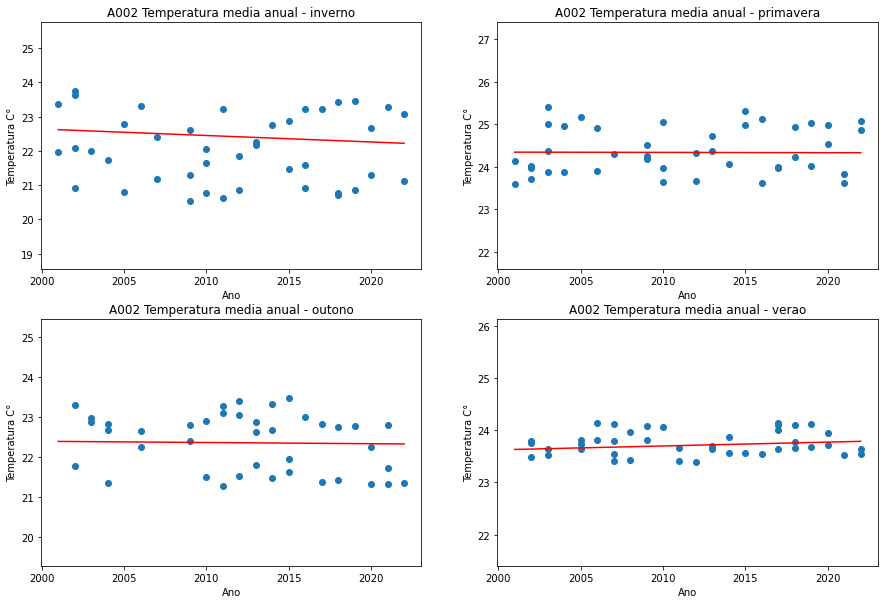

In [10]:
plot_reg_seasons(medidores[5], coefs_monthly)

In [11]:
def clean_coefs(coefs, q1_perc = 0.05, q3_perc = 0.95):
    n_coefs = {}
    
    for season in seasons:
        # Intervalo 5%-95% -> removendo 10% dos valores extremos
        Q1 = np.quantile(coefs[season], q1_perc)
        Q3 = np.quantile(coefs[season], q3_perc)
        
        n_coefs[season] = [val for val in coefs[season] if (val <= Q3) and (val >= Q1)]
    return n_coefs

In [12]:
n_coefs = clean_coefs(ests_monthly)

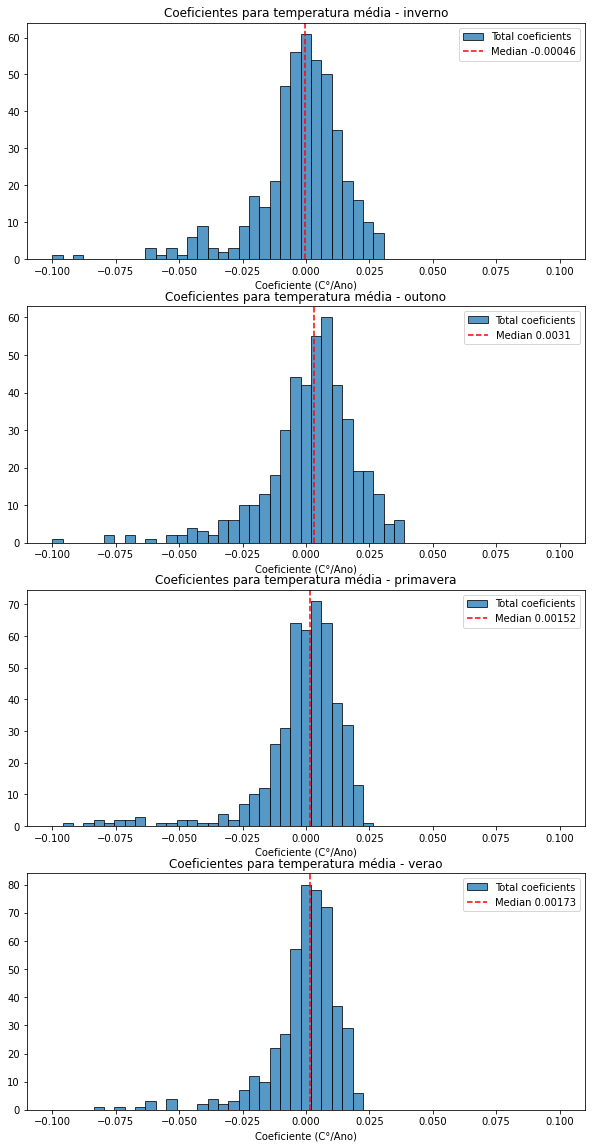

In [13]:
# Distribution of coefficients along the stations for all of Brazil
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 20), sharex=True)
n_bins = np.linspace(-0.1, 0.1, 50)
i = 0
for season in seasons:
    mea = np.median(n_coefs[season])
    axs[i].hist(n_coefs[season], bins=n_bins, histtype="bar", ec="black", alpha=0.75, label="Total coeficients")
    axs[i].axvline(mea, color="r", linestyle="dashed", label=f"Median {round(mea, 5)}")
    axs[i].set_title(f"Coeficientes para temperatura média - {season}")
    axs[i].set_xlabel("Coeficiente (C°/Ano)")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].legend()
    i += 1
plt.show()

In [14]:
# Separando para cada regiao do Brasil
df_stations = pd.read_csv("./dataset/STATION_DATA.CSV", delimiter=";", decimal=",")
df_stations

,REGIAO,UF,MUNICIPIO,CODIGO,LATITUDE,LONGITUDE,ALTITUDE
0,CO,DF,AGUAS EMENDADAS,A045,-15.596389,-47.625833,1200
1,CO,DF,BRASILIA,A001,-15.789444,-47.925833,"1159,54"
2,CO,DF,BRAZLANDIA,A042,-15.599722,-48.131111,1143
3,CO,DF,GAMA (PONTE ALTA),A046,-15.935278,-48.137500,990
4,CO,DF,PARANOA (COOPA-DF),A047,-16.011111,-47.557500,1043
...,...,...,...,...,...,...,...
629,SE,SP,SOROCABA,A713,-23.350000,-47.666667,609
630,SE,SP,TAUBATE,A728,-23.041944,-45.520278,571
631,SE,SP,TUPA,A768,-21.927222,-50.490278,498
632,SE,SP,VALPARAISO,A734,-21.319167,-50.930278,374


In [17]:
# Group stations by region
regions = df_stations["REGIAO"].unique()
stations_region = {}
for region in regions:
    stations_region[region] = df_stations[df_stations["REGIAO"] == region]["CODIGO"]
    
def get_slopes(coefs):
    ests = {}
    for idx in range(4):
            ests[seasons[idx]] = []
    for l in coefs:
        for idx in range(4):
            ests[seasons[idx]].append(l[idx][0])
    return ests

def plot_region(uf, q1, q3):
    coefs_reg = []
    for medidor in stations_region[uf]:
        if medidor in coefs_monthly.keys():
            coefs_reg.append(coefs_monthly[medidor])
    slopes_reg = get_slopes(coefs_reg)
    clean_reg = clean_coefs(slopes_reg, q1, q3)
    # Distribution of coefficients along the stations for all of the region
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 20), sharex=True)
    min_bound = min(min(clean_reg["inverno"]), min(clean_reg["outono"]), min(clean_reg["verao"]), min(clean_reg["primavera"]))
    max_bound = max(max(clean_reg["inverno"]), max(clean_reg["outono"]), max(clean_reg["verao"]), max(clean_reg["primavera"]))
    n_bins = np.linspace(min_bound, max_bound, 20)
    i = 0
    for season in seasons:
        mea = np.median(clean_reg[season])
        axs[i].hist(clean_reg[season], bins=n_bins, histtype="bar", ec="black", alpha=0.75, label="Total coeficients")
        axs[i].axvline(mea, color="r", linestyle="dashed", label=f"Median {round(mea, 5)}")
        axs[i].set_title(f"Coeficientes para temperatura média - {regioes[uf]} - {season}")
        axs[i].set_xlabel("Coeficiente (C°/Ano)")
        axs[i].xaxis.set_tick_params(labelbottom=True)
        axs[i].legend()
        i += 1
    plt.show()
    return clean_reg

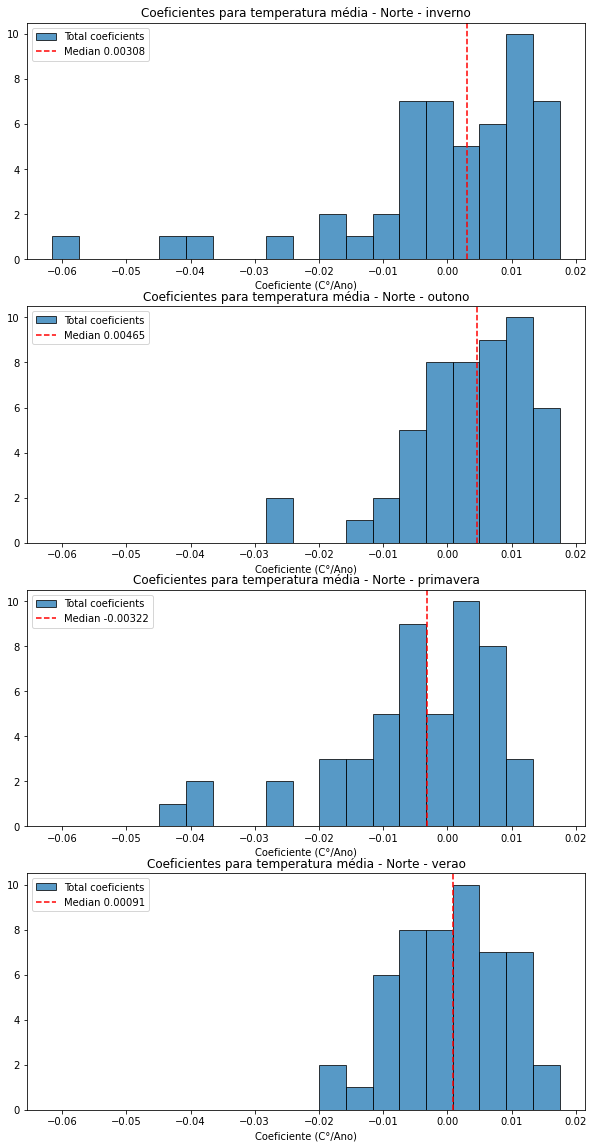

In [18]:
# Norte
clean_norte = plot_region("N", 0.25, 0.9)

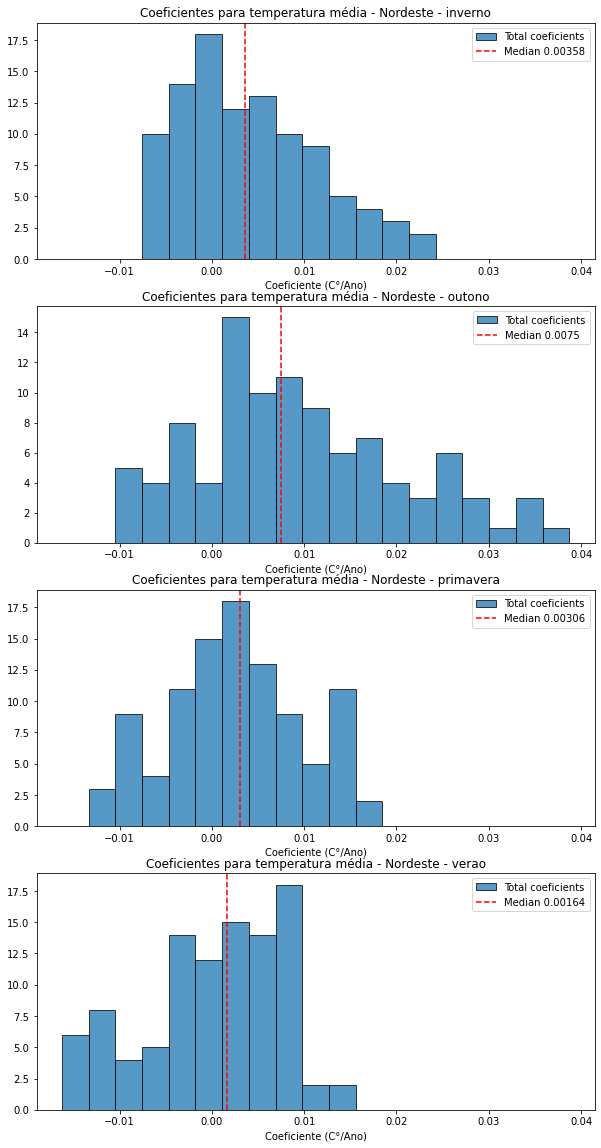

In [19]:
# Nordeste
clean_norte = plot_region("NE", 0.15, 0.9)

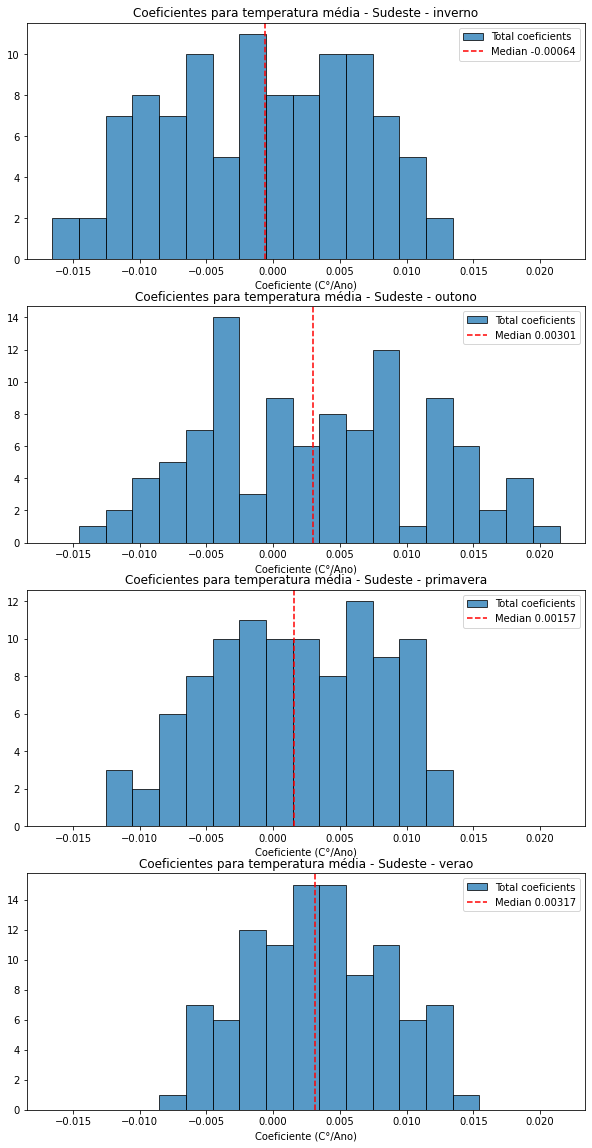

In [20]:
# Sudeste
clean_norte = plot_region("SE", 0.15, 0.9)

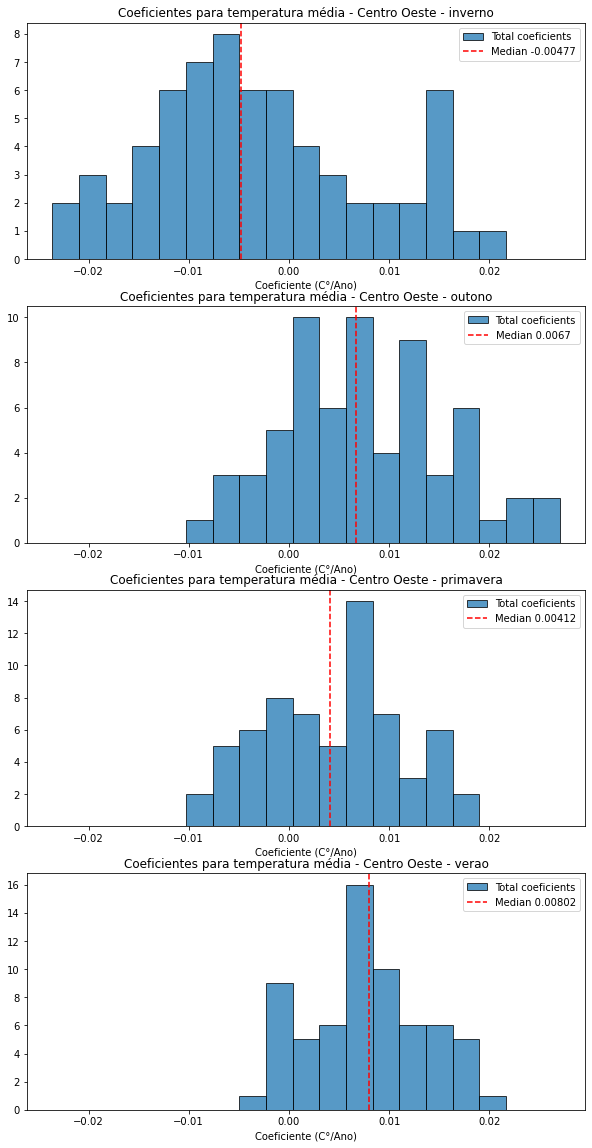

In [21]:
# Centro Oeste
clean_norte = plot_region("CO", 0.15, 0.9)

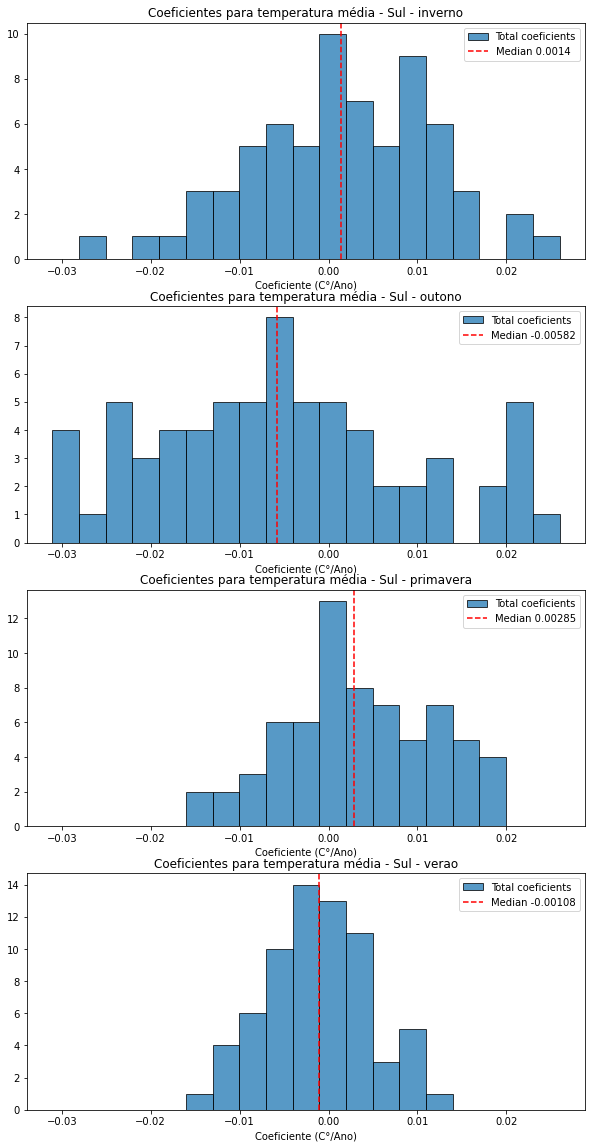

In [22]:
# Sul
clean_norte = plot_region("S", 0.15, 0.9)